# Histopathologic Cancer Detection Challenge
- Author: Tim Seidel
- Date: 16.06.2025
### CNN Cancer Detection Kaggle Mini - Project
The following notebook aims to predict (binary classification) whether an image contains a tumor tissue or not. To achieve this, I will be: 
1. providing a thorough description of the problem & data, 
2. developing an Exploratory Data Analysis, 
3. building and analyzing multiple model architectures, 
4. performing hyperparameter tuning on these different architectures & showing / analyzing results,
5. and providing a discussion and conclusion. 

### Github Repository: 
https://github.com/tseidel0509/Deep_Learning/blob/main/cnn_cancerDetection.ipynb

### Data Source: 
As part of this project, data will be used from the Histopathologic Cancer Detection Kaggle Project. Specifically, I would like to cite: 
- Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle. 


In [ ]:
# Standard libraries
import os
import gc
import random
import math

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tqdm.auto import tqdm as auto_tqdm

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

# Scikit-learn
from sklearn.model_selection import train_test_split

## Step 1: Description of Problem, CNNs, and Data
"Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data."
- While the instructions refer to NLP, I assume this is a typo and a description of CNNs is to be provided. 

#### Step 1.1 Problem Description: 
The goal, given images (96x96) from histopathologic scans of lymph node sections, is to predict whether the center 32x32 region contains at least one pixel of tumor tissue. The task is framed as a binary classification problem: 
- label = 1 -> tumor present, 
- label = 0 -> tumor absent. 

Tumor tissues that lie outside the center 32x32 region shall not influence the label.

Evaluation is based on the area under the ROC curve between the predicted probability and the observed target. 

#### Step 1.2 CNN Description: 
A Convolutional Neural Network learns via the process of sliding, shared filters over an image to pick out patterns. While early layers detect simple features such as edges and colours, deeper layers understand more complex combinations of features and identify greater portions of the image. Finally, it identifies the intended object via a fully connected final layer. Generally a good starting point is to use an architecture consisting of 2 convolutional layers followed by a Pooling Layer. Depending on the size and complexity of the data one could add multiples of this combination to create the CNN. The Fully Connected final layer performs the task of classification based on the hidden layers output. 

#### Step 1.3 Data Description: 
The dataset consists of train and test images of size 96x96 from the original PatchCamelyon (PCam) dataset, without duplicates. 
- Training Data: consists of approx. 220k TIFF images of size 96x96
- Test data: consists of approx. 57k TIFF images of size 96x96
- train_labels.csv: contains the labels corresponding to each train image id. Hence consists of two columns id, and label



## Step 2: Exploratory Data Analysis
"Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?"

In [ ]:
ROOT_DIR = "/Users/timseidel/Documents/Graduate_Certificate/CNN_CancerDetection/histopathologic-cancer-detection"
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
TEST_DIR = os.path.join(ROOT_DIR, "test")
LABELS_CSV = os.path.join(ROOT_DIR, "train_labels.csv")

labels_df = pd.read_csv(LABELS_CSV)

class PCam(Dataset):
    # df: DataFrame with at least an id column and optionally a label
    # img_dir: folder that physically stores the image
    # transform: preprocessing pipeline 
    # idx: numeric index
    def __init__(self, df, img_dir, transform = None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]["id"]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        img = Image.open(img_path)
        img = self.transform(img) # transforms to a 3 x 96 x 96 float32 tensor
        label = self.df.iloc[idx].get("label", -1) # if the DF lacks a label column (i.e. test data) .get()  returns -1 as a placeholder
        return img, label, img_id

test_ids = pd.DataFrame({
    "id": [f[:-4] for f in os.listdir(TEST_DIR) if f.endswith(".tif")]
})
test_df = PCam(test_ids, TEST_DIR)

#### Step 2.1 Basic Inspection:


In [3]:
print("Number of images in train directory: ", sum(f.endswith(".tif") for f in os.listdir(TRAIN_DIR)))
print("Number of images in test directory: ", sum(f.endswith(".tif") for f in os.listdir(TEST_DIR)))
print("Shape of the labels dataframe:", labels_df.shape, "\n")
print("First couple rows of the labels:", labels_df.head())
print("\nNumber of negative vs. positive labels:\n", labels_df["label"].value_counts())

Number of images in train directory:  220025
Number of images in test directory:  57458
Shape of the labels dataframe: (220025, 2) 

First couple rows of the labels:                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Number of negative vs. positive labels:
 label
0    130908
1     89117
Name: count, dtype: int64


#### Step 2.2 Cleaning: Check Duplicates or Missing Images (label IDs vs Train IDs)

In [ ]:
dup_rows = labels_df.duplicated("id").sum()
missing = [img_id for img_id in labels_df["id"]
           if not os.path.exists(os.path.join(TRAIN_DIR, f"{img_id}.tif"))]

print(f"Duplicate rows in Labels: {dup_rows}")
print(f"Number of Missing images: {len(missing)}")

Duplicate rows in Labels: 0
Number of Missing images: 0


Given that there exist no duplicate rows in the labels dataset and also all training images are accounted for, no cleaning is necessary. 

#### Step 2.3: Label Distribution

<function matplotlib.pyplot.show(close=None, block=None)>

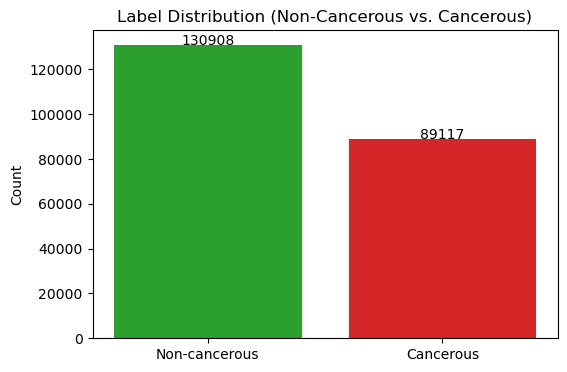

In [5]:
non_cancerous = (labels_df["label"] == 0).sum()
cancerous = (labels_df["label"] == 1).sum()
labels = ["Non-cancerous", "Cancerous"]
counts = [non_cancerous, cancerous]
colors=["tab:green", "tab:red"]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts, color = colors)

for idx, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, counts[idx], str(counts[idx]), ha="center")

plt.title("Label Distribution (Non-Cancerous vs. Cancerous)")
plt.ylabel("Count")
plt.show

#### Step 2.4: Class Proportion

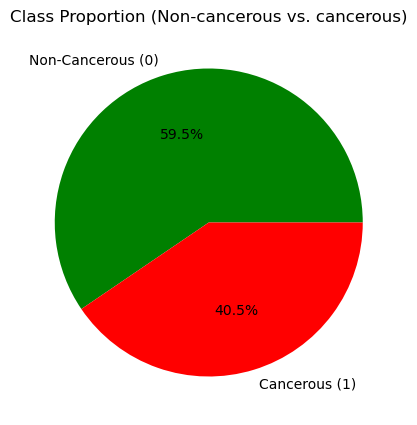

In [6]:
label_counts = labels_df["label"].value_counts()
plt.figure(figsize=(5,5))
plt.pie(label_counts, labels = ["Non-Cancerous (0)", "Cancerous (1)"],autopct="%1.1f%%", colors=["green", "red"])
plt.title("Class Proportion (Non-cancerous vs. cancerous)")
plt.show()

#### Step 2.5: Display Cancerous vs. Non-Cancerous images

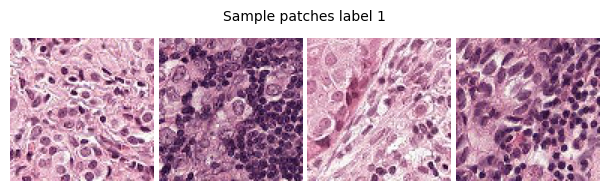

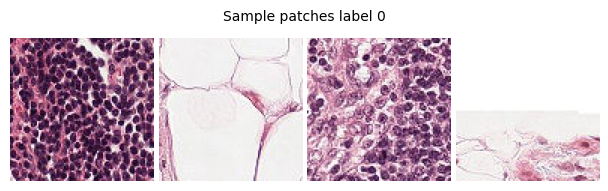

In [7]:
def plot_grid(df, label, n=4):
    ids = df[df["label"]==label].sample(n)["id"].tolist()
    fig, axes = plt.subplots(1, n, figsize=(6, 4))
    for ax, img_id in zip(axes.flatten(), ids):
        ax.imshow(Image.open(os.path.join(TRAIN_DIR, f"{img_id}.tif")))
        ax.axis("off")
    for ax in axes.flatten()[len(ids):]:
        ax.remove()
    fig.tight_layout(pad=0.4)
    fig.suptitle(f"Sample patches label {label}", fontsize=10, y=0.75)
    plt.show()

plot_grid(labels_df, label=1)
plot_grid(labels_df, label=0)

## Step 3: Building and Analyzing Multiple Models
#### Step 3.1: Train / Validation Split

In [ ]:
train_labels, valid_labels = train_test_split(
    labels_df, test_size = 0.2, stratify = labels_df["label"], random_state=42
)

train_labels = train_labels.reset_index(drop=True)
valid_labels = valid_labels.reset_index(drop=True)
print("Train label distribution: \n", train_labels["label"].value_counts(normalize=True))
print("Validation label distribution: \n", valid_labels["label"].value_counts(normalize=True))

Train label distribution: 
 label
0    0.594966
1    0.405034
Name: proportion, dtype: float64
Validation label distribution: 
 label
0    0.594978
1    0.405022
Name: proportion, dtype: float64


The class proportion is equal to the class proportion shown in step 2.4, guaranteeing the same distribution after train / validation splitting. 

In [4]:
train_df = PCam(train_labels, TRAIN_DIR)
valid_df = PCam(valid_labels, TRAIN_DIR)
print(f"Length of train_df = {len(train_df):,} samples")
print(f"Length of valid_df = {len(valid_df):,} samples")

Length of train_df = 176,020 samples
Length of valid_df = 44,005 samples


In [ ]:
DEVICE = ("mps" if torch.backends.mps.is_available()
          else "cuda" if torch.cuda.is_available()
          else "cpu")
print(DEVICE)

mps


In [6]:
BATCH_SIZE = 64

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])
valid_tf = transforms.ToTensor()
train_df.transform = train_tf
valid_df.transform = valid_tf

train_loader = DataLoader(train_df, batch_size=BATCH_SIZE, shuffle = True, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_df, batch_size=BATCH_SIZE, shuffle = False, num_workers=0, pin_memory=False)

#### 3.2 Build and Train SqueezeNet with transfer learning
This is a convolutional neural network that employes so-called fire-modules to compress information and then simple expansion layers to rebuild it. 

Specifically, the squeeze layers are: 
- 1x1 convolutional layers that reduce the channel count with ReLu activation function. The expansion layers are:
- a mix of 1x1 and 3x3 convolutional layers that together expand the channels back with ReLu activation functions

The combination of squeeze and expand constitute a Fire Module. 

The total architecture is set up as follows: 
- It begins with a 7x7 conv. layers, followed by a 3x3 max pooling layer. 
- Then 8 fire modules (with the occasional max pooling layer in-between)
- a final convolutional layer to map the classes and then a global avg-pool layers

The benefit of SqueezeNet is that it is quite fast at training as a result of its parameter efficiency. But it is quite shallow and has less representational capacity. Given that it has a small model size and fast computation speeds it is well suited as a baseline, sanity-check model. 

[01/10] train: loss 0.5957 • acc 73.490% | valid: loss 0.5859 • acc 83.697%


[02/10] train: loss 0.5702 • acc 80.276% | valid: loss 0.6231 • acc 81.468%


[03/10] train: loss 0.5608 • acc 81.556% | valid: loss 0.5509 • acc 82.307%


[04/10] train: loss 0.5553 • acc 82.491% | valid: loss 0.5431 • acc 84.445%


[05/10] train: loss 0.5508 • acc 83.198% | valid: loss 0.5553 • acc 86.670%


[06/10] train: loss 0.5473 • acc 83.777% | valid: loss 0.5561 • acc 86.686%


[07/10] train: loss 0.5449 • acc 84.139% | valid: loss 0.5544 • acc 87.361%


[08/10] train: loss 0.5426 • acc 84.403% | valid: loss 0.5355 • acc 84.456%


[09/10] train: loss 0.5401 • acc 84.623% | valid: loss 0.5313 • acc 87.545%


[10/10] train: loss 0.5384 • acc 84.886% | valid: loss 0.5321 • acc 87.810%


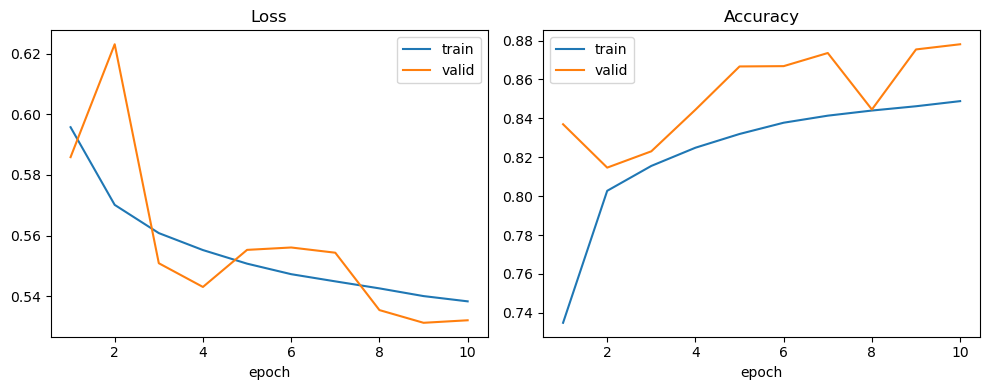

In [ ]:
model = models.squeezenet1_1(weichts=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Conv2d(512, 2, kernel_size=1)
pos = train_labels["label"].mean()
neg = 1 - pos
b = math.log(pos / neg)
model.classifier[1].bias.data.fill_(b)
model.num_classes = 1
model = model.to(DEVICE)

# Loss function and optimizer (no LR scheduling and using SGD without momentum)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Helper function
def step(loader, train=False):
    mode = "train" if train else "valid"
    model.train() if train else model.eval()
    running_loss = 0.0
    running_correct = 0
    n = 0
    pbar = tqdm(loader, desc = mode, leave = False)
    for x,y, _ in pbar:
        x, y = x.to(DEVICE), y.float().to(DEVICE).unsqueeze(1)
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss.backward()
                optimizer.step()
        preds = torch.sigmoid(logits) > 0.5.float()
        running_loss += loss.item() * x.size(0)
        running_correct += (preds == y).sum().item()
        n += x.size(0)
        pbar.set_postfix(loss = loss.item())
    return running_loss / n, running_correct / n

# Training Loop
EPOCHS = 10
history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": []}

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss, train_acc = step(train_loader, train=True)
    valid_loss, valid_acc = step(valid_loader, train=False)
    
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_acc)
    history["valid_acc"].append(valid_acc)
    
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss {train_loss:.4f} •  acc: {train_acc:.4f} | "
          f"valid: loss {valid_loss:.4f} •  acc: {valid_acc:.4f}")
    
# Plot Train vs. Valid Losses and Accuracies per Epoch
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="train")
plt.plot(epochs, history["valid_loss"], label="valid")
plt.title("Loss")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="train")
plt.plot(epochs, history["valid_acc"], label="valid")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.tight_layout()
plt.show()

#### Quick Summary & Analysis of SqueezeNet Results
The current set-up with SqueezeNet tops out at approx. 88% validation accuracy. The loss shows that the convergence has not completed after 10 epochs. Addtionally, there are signs of under-fitting given the validation accuracy is always higher than the train accuracy. This is evidence that the task could profit from a higher capacity model. 

#### Step 3.3 Techniques to Improve Performance
The previous model used plain SGD with a relatively low learning rate and no scheduling. Also the model is relatively shallow with just approx. 1 million parameters. The goal of the following implementation is to improve the accuracy. The following changes will be applied: 
- Model: ResNet-18, which consists of residual blocks and has almost 12 million parameters to learn richer texture and color cues which are crucial for histoplathology
- AdamW instead of SGD: AdamW employs momentum, which gives a faster early descent and more stable late-stage fine tuning.
- Learning Rate scheduling: instead of a fixed LR, cosine annealing will be used to first aggressively then smoothly shrink the LR rate, allowing the model to better find global minima instead of jumping 
- Regularisation: AdamW uses built-in regularisation to reduce the risk of overfitting 

#### Step 3.4: Build and Train ResNet18 with Improvements from Step 3.3
ResNet-18 is an 18 layer convolutional neural network. It starts off with a 7x7 conv. layers, followed by a max_pooling layer. Then the first residual block begins, which consists of two 3x3 conv layers. After the second conv. layer, the block adds its input back to the output before applying the ReLU activation. This is the so-called skip-connection. These residual blocks are repeated multiple times. Then follows a global average pool layer and finally a fully connected layer. In this case the 1000-way classifier is replaced with a single output neuron to accomodate for the binary tumour detection problem. 

ResNet-18 is well qualified for this binary classification task because the residual connections let gradients flow more smoothly making is easier to train while ensuring that it is deep enough to learn complex textures. 

/opt/anaconda3/envs/cnndetection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[01/10] train: loss 0.2274 • acc 90.975% | valid: loss 0.1909 • acc 92.887%


[02/10] train: loss 0.1757 • acc 93.363% | valid: loss 0.1741 • acc 93.210%


[03/10] train: loss 0.1559 • acc 94.173% | valid: loss 0.1307 • acc 95.257%


[04/10] train: loss 0.1390 • acc 94.851% | valid: loss 0.1331 • acc 95.185%


[05/10] train: loss 0.1240 • acc 95.487% | valid: loss 0.1183 • acc 95.757%


[06/10] train: loss 0.1096 • acc 96.023% | valid: loss 0.0965 • acc 96.598%


[07/10] train: loss 0.0981 • acc 96.480% | valid: loss 0.0958 • acc 96.619%


[08/10] train: loss 0.0875 • acc 96.880% | valid: loss 0.0810 • acc 97.175%


[09/10] train: loss 0.0791 • acc 97.174% | valid: loss 0.0768 • acc 97.400%


[10/10] train: loss 0.0744 • acc 97.372% | valid: loss 0.0740 • acc 97.491%


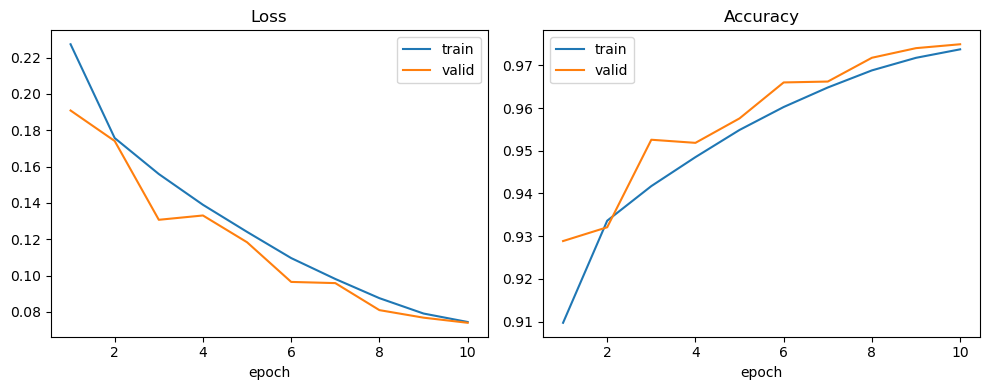

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1) # Swap fully connected output layer with 1000 logits for a single logit (binary)
model = model.to(DEVICE)

# Loss, optimizer, and Learning Rate Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
schuduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10) # shrinks the learning rate following a cosine curve


# Helper function
def step(loader, train=False):
    mode = "train" if train else "valid"
    model.train() if train else model.eval()
    running_loss = 0.0
    running_correct = 0
    n = 0
    pbar = tqdm(loader, desc = mode, leave = False)
    for x,y, _ in pbar:
        x, y = x.to(DEVICE), y.float().to(DEVICE).unsqueeze(1)
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss.backward()
                optimizer.step()
        preds = torch.sigmoid(logits) > 0.5.float()
        running_loss += loss.item() * x.size(0)
        running_correct += (preds == y).sum().item()
        n += x.size(0)
    return running_loss / n, running_correct / n

# Training Loop
EPOCHS = 10
history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": []}

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss, train_acc = step(train_loader, train=True)
    valid_loss, valid_acc = step(valid_loader, train=False)
    
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_acc)
    history["valid_acc"].append(valid_acc)
    
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss {train_loss:.4f} •  acc: {train_acc:.4f} | "
          f"valid: loss {valid_loss:.4f} •  acc: {valid_acc:.4f}")
    
# Plot Train vs. Valid Losses and Accuracies per Epoch
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="train")
plt.plot(epochs, history["valid_loss"], label="valid")
plt.title("Loss")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="train")
plt.plot(epochs, history["valid_acc"], label="valid")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.tight_layout()
plt.show()

#### Quick Summary & Analysis of ResNet-18 Results
The results from the plot show a steady downward trending loss, that never ticks up for more than a single epoch. Given that the accuracy on validation is slightly higher, it appears the model has learned to generalize well, in fact it may be slightly underfitting. Perhaps, the validation set is slightly easier. Given that the loss at 10 epoch shows near-parity it appears that the model has effectively saturated the signal it can extract from the dataset given the current hyperparameters. Also the result achieved on validation of 97+% is strong and clearly outperforms the SqueezeNet baseline I experimented with earlier on. 

In [ ]:
MODEL_PATH = "pcam_resnet18_weights.pth"
torch.save(model.state_dict(), MODEL_PATH)

## Step 4: Hyperparameter Tuning + Results & Analysis
While I already improved performance with the steps outlined in 3.3, I shall be employing hyperparameter tuning to try to find the best combination of values to retrain the ResNet-18 model and then predict on the test set. The tuning follows the following procedure: 
1. Tune on a subset of data: ResNet on the full set would take hours to tune. By sampling 5% of the images, the epoch time is cut by approximately 20x whilst keeping the class balance and augmentation. This ensures the ranking of the hyperparameters is preserved
2. Defining a search space: I chose to tune learning rate, weight decay, the momentum, cosine scheduling, drop out before final fully connected layer and how many early ResNet blocks to freeze
3. Random Search: I am performing random search instead of exhaustively tuning over the entire search space in order to reduce the number of combinations. Specifically, I chose 15 trials
4. Training: for each trial I build and train a fresh model with 3 epochs 
5. I keep track of the best trial so far and then output the winning hyperparameters

#### Step 4.1 Hyperparameter Tuning


Trial 1/15: {'lr': 0.0001, 'wd': 1e-05, 'beta1': 0.95, 'T_max': 8, 'drop_p': 0.0, 'freeze_n': 0}


/opt/anaconda3/envs/cnndetection/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


finished with val acc 91.091%
New current best

Trial 2/15: {'lr': 0.0003, 'wd': 1e-05, 'beta1': 0.9, 'T_max': 8, 'drop_p': 0.2, 'freeze_n': 0}


finished with val acc 91.182%
New current best

Trial 3/15: {'lr': 0.0001, 'wd': 0.0001, 'beta1': 0.9, 'T_max': 4, 'drop_p': 0.5, 'freeze_n': 2}


finished with val acc 90.364%

Trial 4/15: {'lr': 0.0001, 'wd': 1e-05, 'beta1': 0.95, 'T_max': 8, 'drop_p': 0.0, 'freeze_n': 0}


finished with val acc 90.455%

Trial 5/15: {'lr': 0.0003, 'wd': 1e-06, 'beta1': 0.85, 'T_max': 8, 'drop_p': 0.5, 'freeze_n': 0}


finished with val acc 91.545%
New current best

Trial 6/15: {'lr': 0.0001, 'wd': 1e-06, 'beta1': 0.9, 'T_max': 6, 'drop_p': 0.2, 'freeze_n': 2}


finished with val acc 91.045%

Trial 7/15: {'lr': 5e-05, 'wd': 0.0001, 'beta1': 0.95, 'T_max': 4, 'drop_p': 0.0, 'freeze_n': 2}


finished with val acc 90.091%

Trial 8/15: {'lr': 0.0001, 'wd': 1e-05, 'beta1': 0.9, 'T_max': 6, 'drop_p': 0.5, 'freeze_n': 2}


finished with val acc 90.773%

Trial 9/15: {'lr': 5e-05, 'wd': 1e-05, 'beta1': 0.9, 'T_max': 4, 'drop_p': 0.2, 'freeze_n': 0}


finished with val acc 89.909%

Trial 10/15: {'lr': 0.0001, 'wd': 0.0001, 'beta1': 0.9, 'T_max': 8, 'drop_p': 0.0, 'freeze_n': 0}


finished with val acc 91.136%

Trial 11/15: {'lr': 5e-05, 'wd': 1e-06, 'beta1': 0.85, 'T_max': 8, 'drop_p': 0.5, 'freeze_n': 2}


finished with val acc 88.773%

Trial 12/15: {'lr': 0.0001, 'wd': 1e-06, 'beta1': 0.95, 'T_max': 8, 'drop_p': 0.5, 'freeze_n': 0}


finished with val acc 90.864%

Trial 13/15: {'lr': 0.001, 'wd': 1e-06, 'beta1': 0.85, 'T_max': 8, 'drop_p': 0.2, 'freeze_n': 2}


finished with val acc 87.318%

Trial 14/15: {'lr': 5e-05, 'wd': 1e-06, 'beta1': 0.95, 'T_max': 8, 'drop_p': 0.0, 'freeze_n': 2}


finished with val acc 90.500%

Trial 15/15: {'lr': 0.0001, 'wd': 1e-05, 'beta1': 0.9, 'T_max': 8, 'drop_p': 0.5, 'freeze_n': 2}


finished with val acc 90.682%

=== BEST CONFIG ON SUBSET ===
accuracy 91.545% with {'lr': 0.0003, 'wd': 1e-06, 'beta1': 0.85, 'T_max': 8, 'drop_p': 0.5, 'freeze_n': 0}


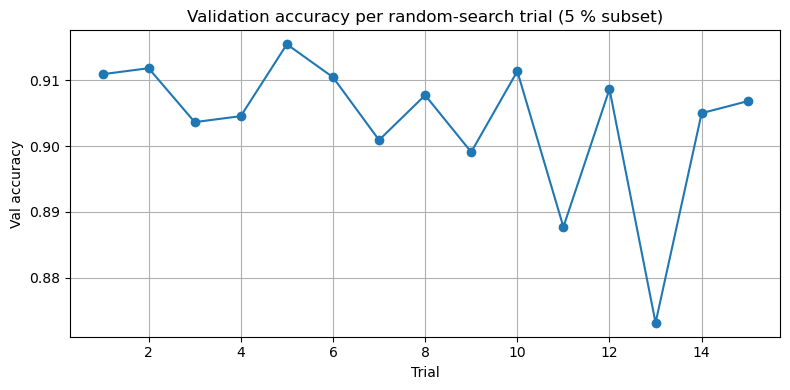

In [ ]:
# Subset DataLoader for Tuning
def subset_loader(full_loader, frac, *, shuffle = False):
    n_subset = int(len(full_loader.dataset) * frac)
    idxs = np.random.choice(len(full_loader.dataset), n_subset, replace=False)
    subset = Subset(full_loader.dataset, idxs)
    return DataLoader(
        sub_ds,
        batch_size = full_loader.batch_size,
        shuffle = shuffle,
        num_workers = 0,
        pin_memory = False,
    )

train_small = subset_loader(train_loader, 0.05, shuffle=True)
valid_small = subset_loader(valid_loader, 0.05, shuffle=False)

# Hyperparameter Search Space (Grid)
search_space = {
    "lr": [5e-5, 1e-4, 3e-4, 1e-3],
    "wd": [1e-6, 1e-5, 1e-4],
    "beta1":[0.85, 0.9, 0.95],
    "T_max": [4, 6, 8],
    "drop_p": [0.0, 0.2, 0.5],
    "freeze_n": [0, 2],
}

def random_config(space):
    return {k: random.choice(v) for k, v in space.items()}

N_TRIALS = 15
EPOCHS_PER_TRIAL = 3

# Trial Runner
def run_trial(hp, epochs=EPOCHS_PER_TRIAL):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(
        nn.Dropout(hp["drop_p"]),  # Dropout layer for regularization
        nn.Linear(model.fc.in_features, 1)  # Final output layer for binary classification
    )

    # Freeze layers if specified
    for i, child in enumerate(model.children()):
        if i >= hp["freeze_n"]:
            break
        for p in child.parameters():
            p.requires_grad = False
    
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    opt = optim.AdamW(model.parameters(), lr=hp["lr"], weight_decay=hp["wd"], betas=(hp["beta1"], 0.999))
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=hp["T_max"])

    def epoch_pass(loader, train = False):
        model.train() if train else model.eval()
        tot_loss = correct = n = 0
        for x, y, _ in tqdm(loader, leave = False):
            x, y = x.to(DEVICE), y.float().to(DEVICE).unsqueeze(1)
            with torch.set_grad_enabled(train):
                out = model(x)
                loss = criterion(out, y)
                if train:
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
            preds = torch.sigmoid(out) > 0.5.float()
            tot_loss += loss.item() * x.size(0)
            correct += (preds == y).sum().item()
            n += x.size(0)
        return tot_loss / n, correct / n
    
    # Training on Subset
    for ep in range(1, epochs + 1):
        epoch_pass(train_small, True)
        v_loss, v_acc = epoch_pass(valid_small, False)
        sch.step()
    return v_acc

# Random Search
best_acc = 0.0
best_hp = None
val_curve = []

for trial in range(1, N_TRIALS + 1):
    hp = random_config(search_space)
    print(f"\Trial {trial}/{N_TRIALS}: {hp}")
    acc = run_trial(hp)
    val_curve.append(acc)
    print(f"finished with val acc {acc:.3%}")
    if acc > best_acc:
        best_acc, best_hp = acc, hp
        print("New current best")

print("\n=== BEST CONFIG ON SUBSET ===")
print(f"accuracy {best_acc:.3%} with {best_hp}")

# Ploting Validation Accuracy per Trial
plt.figure(figsize=(8, 4))
plt.plot(range(1, N_TRIALS + 1), val_curve, marker="o")
plt.title("Validation accuracy per random-search trial (5 % subset)")
plt.xlabel("Trial")
plt.ylabel("Val accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

The hyperparameter tuning output the best combination of values based on the validation accuracy. The following step consists of retraining the model using these hyperparameter values and then predicting on the test set for upload to kaggle.

#### Step 4.2: Retrain ResNet Model with Tuned Hyperparameters and Predict on Test

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout layer for regularization
    nn.Linear(model.fc.in_features, 1)  # Final output layer for binary classification
)

# No freeze of any layers

model = model.to(DEVICE)

# Optimizer, schedulur, and loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr = 3e-4,
                        weight_decay = 1e-6,
                        betas = (0.85, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)

# Training Loop
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    # Training Step
    model.train()
    tr_loss = tr_correct = tr_n = 0
    for x, y, _ in tqdm(train_loader, desc = f"train {epoch}/{EPOCHS}", leave = False):
        x, y, = x.to(DEVICE), y.float().to(DEVICE).unsqueeze(1)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = torch.sigmoid(logits) > 0.5.float()
        tr_loss += loss.item() * x.size(0)
        tr_correct += (preds == y).sum().item()
        tr_n += x.size(0)

    # Validation Step
    model.eval()
    va_loss = va_correct = va_n = 0
    with torch.no_grad():
        for x, y, _ in valid_loader;
            x, y = x.to(DEVICE), y.float().to(DEVICE).unsqueeze(1)
            logits = model(x)
            loss = criterion(logits, y)
            preds = torch.sigmoid(logits) > 0.5.float()
            va_loss += loss.item() * x.size(0)
            va_correct += (preds == y).sum().item()
            va_n += x.size(0)
    
    scheduler.step()

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train loss {tr_loss / tr_n:.4f} |  acc {tr_correct / tr_n:.3%} | "
          f"valid: loss {va_loss / va_n:.4f} |  acc {va_correct / va_n:.3%}")
    
# Predict probabilites on the test set and save CSV for upload to Kaggle
test_loader = DataLoader(test_df, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

model.eval()
ids, probs = [], []
with torch.no_grad():
    for x, _, batch_ids in tqdm(test_loader, desc="predict", leave=False):
        x = x.to(DEVICE)
        logits = model(x)
        p = torch.sigmoid(logits).cpu().squeeze(1).numpy()
        ids.extend(batch_ids)
        probs.extend(p)

submission = pd.DataFrame({
    "id": ids,
    "label": probs
})
submission.to_csv("pcam_submission.csv", index=False)
print("Saved pcam_submission.csv")

[01/10] train loss 0.2335 | acc 90.786% | val loss 0.1849 | acc 92.919%


[02/10] train loss 0.1781 | acc 93.259% | val loss 0.1458 | acc 94.767%


[03/10] train loss 0.1542 | acc 94.238% | val loss 0.2173 | acc 92.349%


[04/10] train loss 0.1349 | acc 95.081% | val loss 0.1364 | acc 95.139%


[05/10] train loss 0.1165 | acc 95.797% | val loss 0.1006 | acc 96.489%


[06/10] train loss 0.1036 | acc 96.279% | val loss 0.0888 | acc 96.834%


[07/10] train loss 0.0904 | acc 96.769% | val loss 0.0811 | acc 97.212%


[08/10] train loss 0.0831 | acc 97.055% | val loss 0.0784 | acc 97.312%


[09/10] train loss 0.0803 | acc 97.126% | val loss 0.0781 | acc 97.291%


[10/10] train loss 0.0803 | acc 97.144% | val loss 0.0776 | acc 97.318%


Saved pcam_submission.csv


#### 4.3 Evaluate Baseline ResNet-18 Model on the Test Set (Untuned, for comparison)
In order to put the tuned model into perspective, the following code section shall use the baseline ResNet model, which I trained in step 3.4, to predict on the test set. 

In [ ]:
model = models.resnet18(weights=None)
model.fc.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()
print("✓ model weights loaded")

test_loader = DataLoader(test_df, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

ids, probs = [], []
with torch.no_grad():
    for x, _, batch_ids in tqdm(test_loader, desc="predict"):
        x = x.to(DEVICE)
        logits = model(x)
        p = torch.sigmoid(logits).cpu().squeeze(1).numpy()
        ids.extend(batch_ids)
        probs.extend(p)

# Write Submission File
submission = pd.DataFrame({
    "id": ids,
    "label": probs
})
submission.to_csv("pcam_submission_nohyper.csv", index=False)
print("Saved pcam_submission_nohyper.csv with", len(submission), "rows")

/var/folders/vn/k_0xb64139b7yr555s03m8j00000gn/T/ipykernel_40240/1612209859.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH,

✓ model weights loaded


predict: 100%|██████████| 898/898 [01:04<00:00, 13.96it/s]

Saved pcam_submission_nohyper.csv with 57458 rows


#### 4.4 Results and Analysis


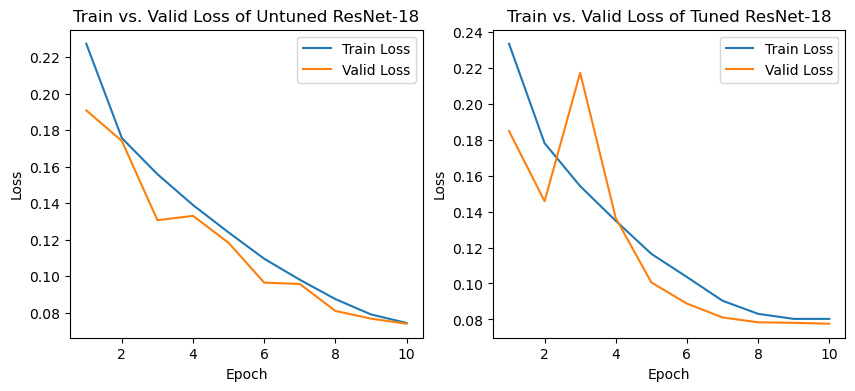

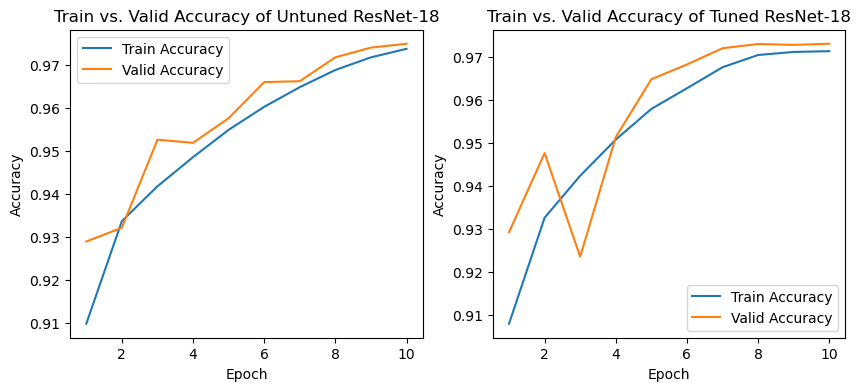

In [ ]:
epochs = list(range(1, 11))
train_loss_resNet = [0.2274, 0.1757, 0.1559, 0.1390, 0.1240, 0.1096, 0.0981, 0.0875, 0.0791, 0.0744]
valid_loss_resNet = [0.1909, 0.1741, 0.1307, 0.1331, 0.1183, 0.0965, 0.0958, 0.0810, 0.0768, 0.0740]
train_acc_resNet = [0.90975, 0.93363, 0.94173, 0.94851, 0.95487, 0.96023, 0.96480, 0.96880, 0.97174, 0.97372]
valid_acc_resNet = [0.92887, 0.93210, 0.95257, 0.95185, 0.95757, 0.96598, 0.96619, 0.97175, 0.97400, 0.97491]

train_loss_resNet_hyper = [0.2335, 0.1781, 0.1542, 0.1349, 0.1165, 0.1036, 0.0904, 0.0831, 0.0803, 0.0803]
valid_losses_resNet_hyper = [0.1849, 0.1458, 0.2173, 0.1364, 0.1006, 0.0888, 0.0811, 0.0784, 0.0781, 0.0776]
train_accs_resNet_hyper = [0.90786, 0.93259, 0.94238, 0.95081, 0.95797, 0.96279, 0.96769, 0.97055, 0.97126, 0.97144]
valid_accs_resnet_hyper = [0.92919, 0.94767, 0.92349, 0.95139, 0.96489, 0.96834, 0.97212, 0.97312, 0.97291, 0.97318]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_resNet, label="Train Loss")
plt.plot(epochs, valid_loss_resNet, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Valid Loss of Untuned ResNet-18")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss_resNet_hyper, label="Train Loss")
plt.plot(epochs, valid_losses_resNet_hyper, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Valid Loss of Tuned ResNet-18")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_acc_resNet, label="Train Accuracy")
plt.plot(epochs, valid_acc_resNet, label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs. Valid Accuracy of Untuned ResNet-18")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs_resNet_hyper, label="Train Accuracy")
plt.plot(epochs, valid_accs_resnet_hyper, label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs. Valid Accuracy of Tuned ResNet-18")
plt.legend()
plt.show()

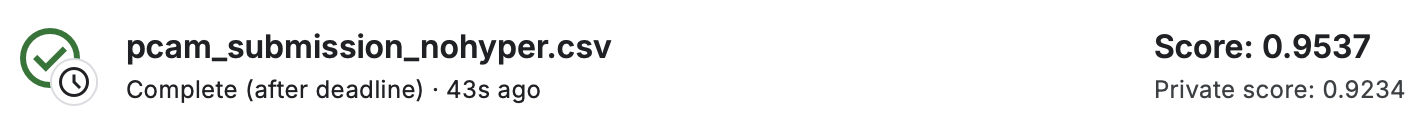
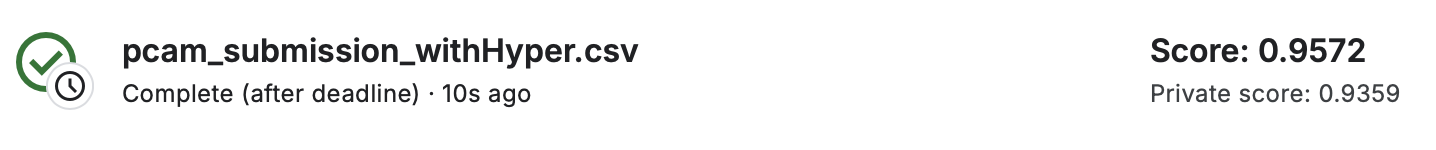

#### The above section consisted of the following:
- Hyperparameter tuning was performed on the ResNet-18 model 
- The ResNet-18 model was retrained using the tuned hyperparameters
- The tuned model was used to predict whether or not the images of the test set are cancerous
- For comparison, the baseline ResNet model was also used to predict on the images of the test set

The procedure for tuning the hyperparameters was outlined in Step 4. The techniques that were applied to improve performance between the SqueezeNet and ResNet model were outlined in Step 3.3.

#### Baseline ResNet vs. SqueezeNet:
The Baseline ResNet model significantly outperformed the SqueezeNet model, this improvement can be attributed to the following differences and changes that were made between the SqueezeNet and baseline ResNet model.
- ResNet-18, consists of residual blocks and has almost 12 million parameters to learn richer texture and color cues which are crucial for histoplathology. SqueezeNet only has approx. 1 million.
- AdamW instead of SGD: AdamW employs momentum, which gives a faster early descent and more stable late-stage fine tuning than SGD without momentum.
- Learning Rate scheduling: instead of a fixed LR, cosine annealing first aggressively then smoothly shrinks the LR rate, allowing the ResNet model to better find global minima instead of jumping 
- Regularisation: AdamW uses built-in regularisation to reduce the risk of overfitting 

Given these improvements the gain in accuracy of almost 10% from 87.8-97.4% on validation makes sense. 

#### Hyperparameter Tuning ResNet-18:
The next step consisted of tuning certain hyperparameters of ResNet-18. Specifically I chose to tune the learning rate, weight decay, the momentum of the AdamW optimizer, cosine scheduling, drop out before final fully connected layer and how many early ResNet blocks to freeze. The grid consisted of the following values: 
- "lr": [5e-5, 1e-4, 3e-4, 1e-3],
- "wd": 1e-6, 1e-5, 1e-4],
- "beta1": [0.85, 0.90, 0.95],
- "T_max": [4, 6, 8],
- "drop_p": [0.0, 0.2, 0.5],
- "freeze_n": [0, 2]

Specifically, I performed a non-exhaustive random search so as to reduce the tuning time. Instead of 10 epochs I defined 3 epochs per trial. Additionally, the tuning was performed on a subset of 5% of the data which also had the goal of reducing tuning time. Whilst a subset was defined, the class balance and augmentations of the data were identical in order to obtain accurate results. 

Whilst tuning did not improve accuracies on the train or test set, as is visible from the plots above, it lead to an improvement in test set predictions. 

#### ROC of Test Set Predictions: 
Given the screenshots above, the evaluation of the test set predictions of the baseline ResNet model resulted in a score of 0.9537. The evaluation score of the tuned ResNet model is 0.9572, approx. 0.4% higher. The improvement is minimal and begs the question of whether the tuning process was worth the wait. While the tuned values lead to a marginal improvement, perhaps the strategy of using a subset of the data and merely 3 epochs per trial did not result in values that generalized to the entire dataset. 

However, one could argue that the baseline model already performed very well. An ROC score of above 0.9 is considered outstanding, therefore tuning may not yield large improvements similarly to tuning RandomForest. 

# Step 5 Conclusion
In conclusion the following takeaways can be highlighted: 
- SqueezeNet: its micro-architecture of just 1 million parameters is good for early sanity checks and speed demos due to quick epochs. Given that it plateaus early (loss continued to fall but accuracy improved more slowly) it does not suit the purpose of leaderboard performance nor should it be used as a benchmark for histopathology
- Baseline ResNet-18: pretrained ResNet-18 model yielded a 10% improvement on accuracy vs. SqueezeNet. Residual blocks + ImageNet pretrained lead to a steady drop in losses and a smooth climb in accuracies. 
- ResNet-18 Hyper. Tuned: whilst the tuning did not increase point accuracy one could argue that it improved calibration and generalisation as reflected in the ROC score. It is likely that the accuracy ceiling had already been reached and saturated. 

In order to improve the ROC score further, it could make sense to monitor the ROC score. Hence, the tuning objective should match the evaluation criterion. Moreover, the plots of both ResNet runs showed that validation accuracy was slightly ahead of training pointing toward the fact that the training data were harder that the validation set. This is a sign that training could be performed on more than 10 epochs without risking overfitting.  

Additionally, it could make sense to analyze the wrongly classified samples, hence an analysis of false-negatives and false positives: 
- False Negative: would classify as missed tumour regions. In reality that would put the patient at direct risk, also the cost of missing a tumour is usually higher than over-calling
- False Positive: would represent a healthy tissue that was flagged as tumour. While this would result in extra workload for doctors and potential anxiety in patients it would generally lead to lower clinical costs and be less of an issue

It could make sense to retrain on false positives and false negatives but a common pitfall would be over-fitting on those specific images. This would require close inspection.  

Whilst I can no longer select my submission to be scored on the leaderboard, my result would place me at place 667. 

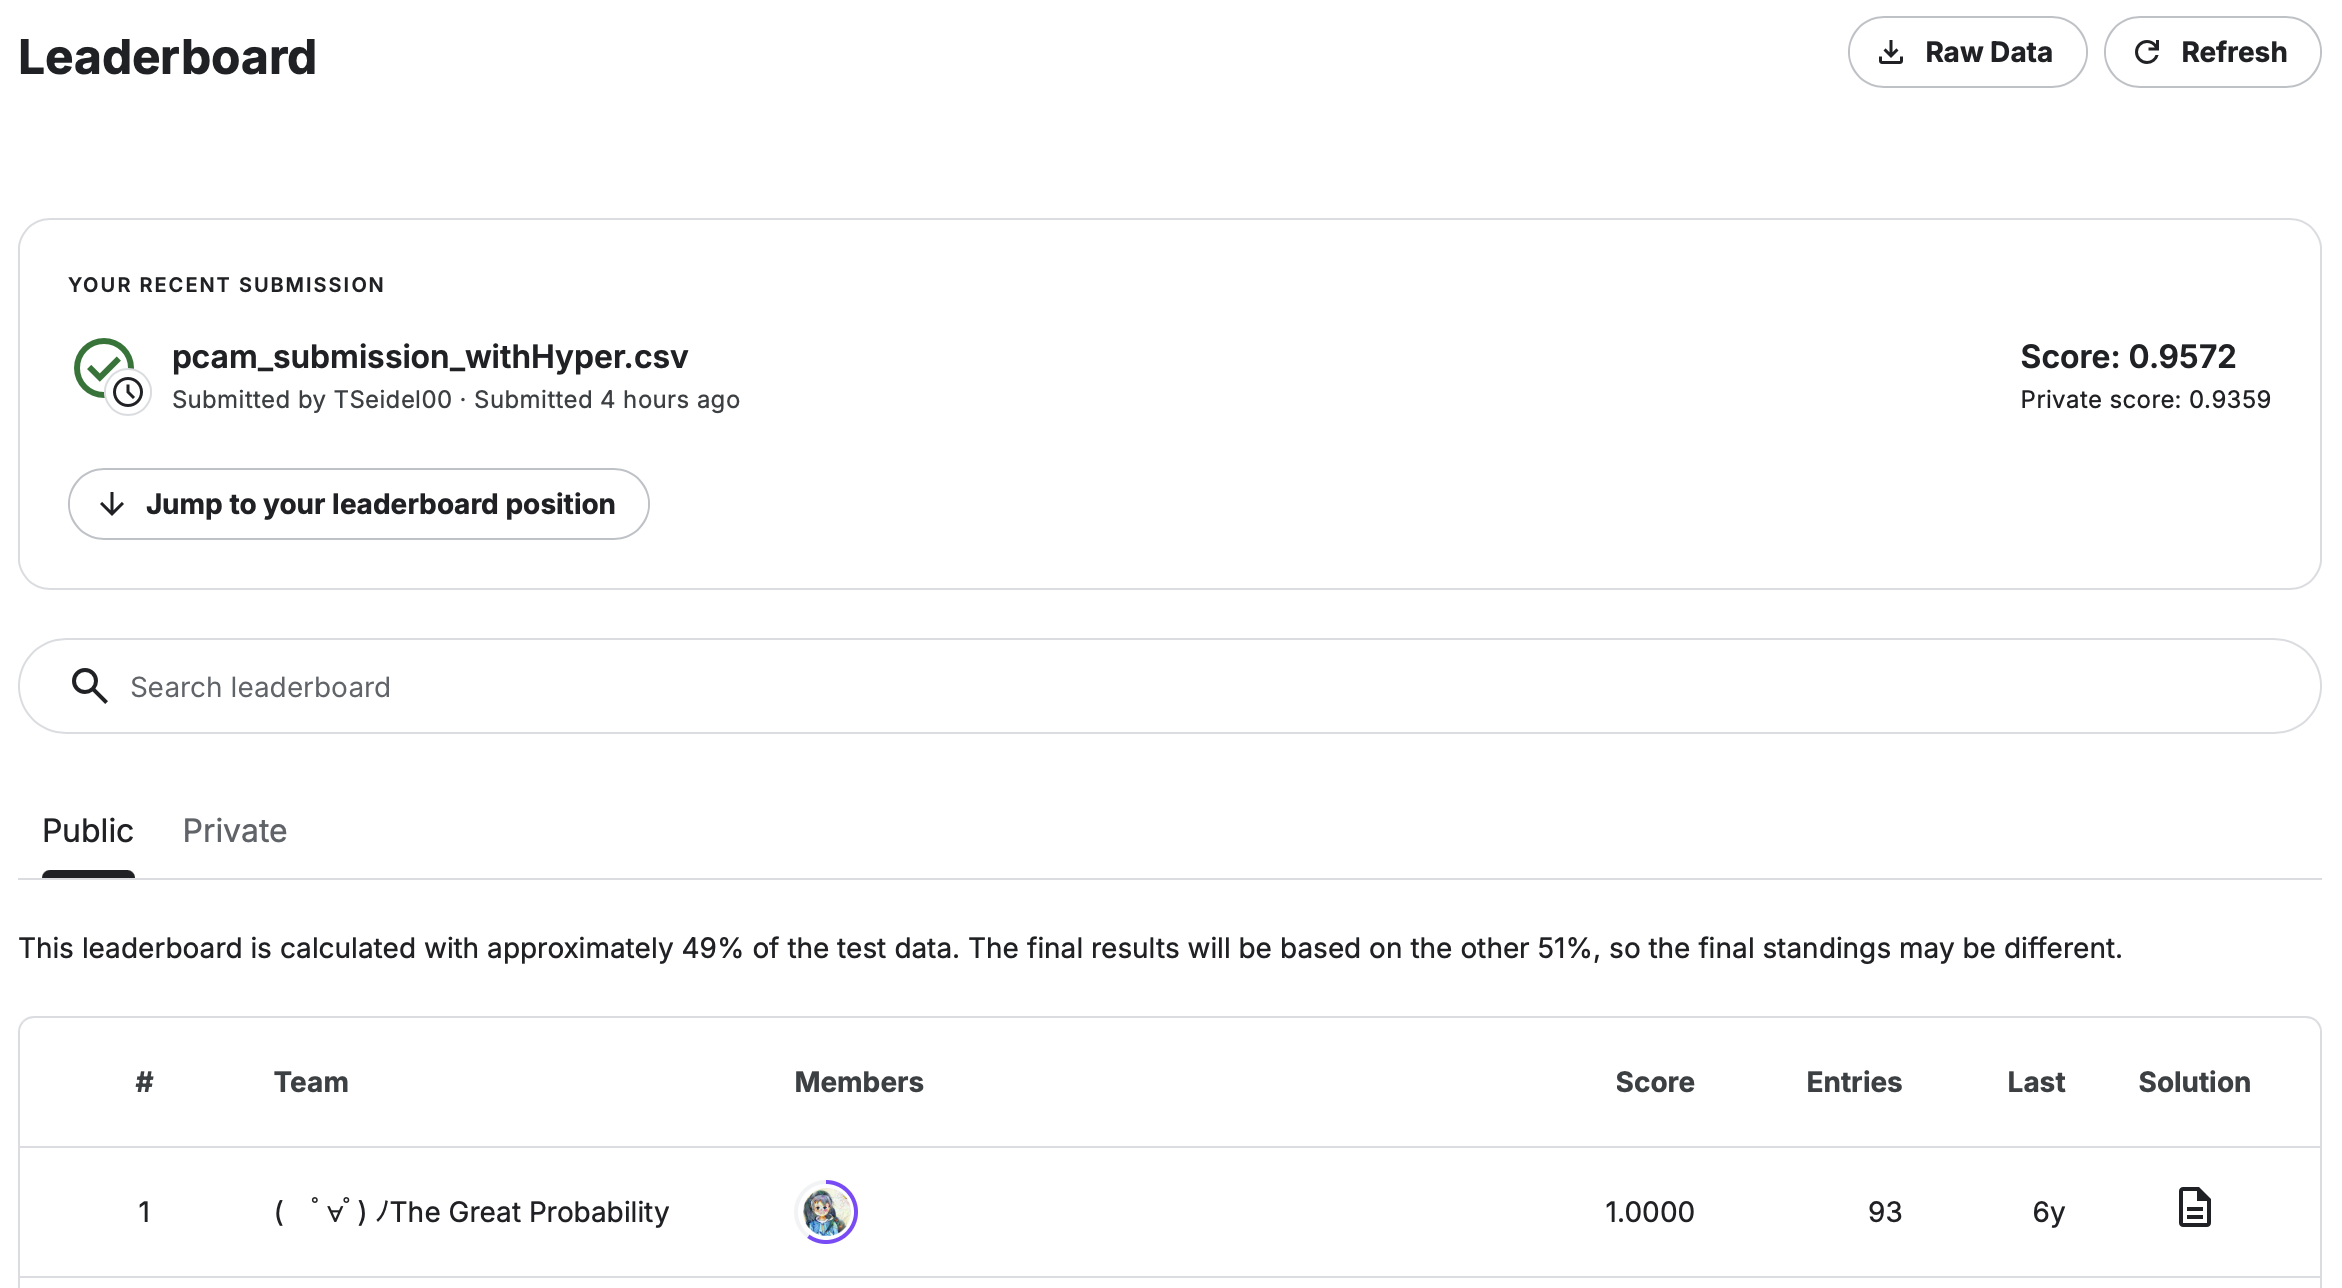